## GRAPH AND IMAGE GENERATOR FOR MDS FINAL PROJECT

First, load in all required packages:

In [1]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Embedding, BatchNormalization, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from keras.metrics import AUC
from sklearn.metrics import precision_score,recall_score, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('float32')

Define custom focal loss for model build:

In [2]:
# Customise loss for model improvement. Gamma and alpha can be set during model build and before loss is calculated
# Focal loss inspired by: https://medium.com/@saptarshimt/object-as-points-anchor-free-object-detection-from-scratch-2019-tensorflow-6170eb815c07
def focal_loss(gamma, alpha):
  # Nest target requirements so they are invoked after loss is used within model 
  def focal_loss_nested(y_true, y_pred):
    # Prevent probabilities from leaving the defined range 
    eps = 1e-8
    y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
    # Selected true class probability -> pt equals the correct label
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    # Returns focal loss mean after computing loss formula
    return -tf.reduce_mean(alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt))
  # Returns calculated focal loss after invoked 
  return focal_loss_nested

Define model structure and hyperparameters:

In [3]:
cnn_model = Sequential([
    Embedding(input_dim=vocab_size,output_dim=32, input_length=300),
    
    Conv1D(16, 4, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPooling1D(),
    
    Bidirectional(LSTM(16, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    GlobalMaxPooling1D(),
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    Dropout(0.3),
    
    # Classify data binarily
    Dense(1, activation='sigmoid', dtype='float32')
], name='CNN_model')

# Compile model, requesting all required performance metrics
# Given the binary nature of target variable, binary accuracy was selected
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    # Custom focal loss is used 
    loss=focal_loss(gamma=2., alpha=0.25), 
    metrics=['BinaryAccuracy', 'Precision', 'Recall', AUC()]
)

NameError: name 'vocab_size' is not defined

Build model and output a model summary:

In [ ]:
cnn_model.build()
cnn_model.summary()

Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 32)        │        20,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 300, 16)        │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 300, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 150, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 150, 32)        │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,057 (105.69 KB)

 Trainable params: 26,961 (105.32 KB)

 Non-trainable params: 96 (384.00 B)

For confusion matrix plotting, define the 4 matrices obtained via prediction runs:

In [ ]:
fm = [[1118126, 326330], 
          [1930617, 2075655]]
sfm = [[1118126, 326330], 
          [696833, 747623]]
mtbm = [[448090, 610717], 
          [91276, 294461]]
smtbm = [[162893, 222844], 
          [91276, 294461]]

matrices = [fm, sfm, mtbm, smtbm]

Plot each confusion matrix by pulling the relevant matrix out of the list:

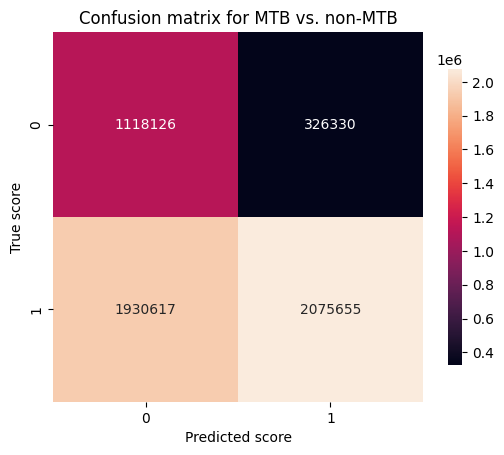

In [ ]:
# Plot a heatmap showing the CNN-BiLSTM confusion matrix
matrix = matrices[0]
sns.heatmap(matrix, square=True, annot=True, fmt="d", cbar_kws={"shrink": 0.8})
plt.title("Confusion matrix for MTB vs. non-MTB")
plt.xlabel("Predicted score")
plt.ylabel("True score")
plt.show()

Load in the saved true classes and predicted classes for both datasets:

In [ ]:
with open("Prediction data/nounder_filtered_preds.pkl", "rb") as fpreds:
    dict = pickle.load(fpreds) 
    y_true = dict.get("y_true")
    y_score = dict.get("y_score")
    filtered_preds = [y_true, y_score]
    
with open("Prediction data/filtered_preds.pkl", "rb") as sfpreds:
    dict = pickle.load(sfpreds) 
    sampled_y_true = dict.get("y_true")
    sampled_y_score = dict.get("y_score")
    sampled_filtered_preds = [sampled_y_true, sampled_y_score]
    
with open("Prediction data/nounder_mtb_preds.pkl", "rb") as mtbpreds:
    dict = pickle.load(mtbpreds) 
    mtb_y_true = dict.get("y_true")
    mtb_y_score = dict.get("y_score")
    mtb_preds = [mtb_y_true, mtb_y_score]
    
with open("Prediction data/mtb_preds.pkl", "rb") as smtbpreds:
    dict = pickle.load(smtbpreds) 
    sampled_mtb_y_true = dict.get("y_true")
    sampled_mtb_y_score = dict.get("y_score") 
    sampled_mtb_preds = [sampled_mtb_y_true, sampled_mtb_y_score]

Check array shape:

In [ ]:
print(repr(y_true)[:200]) 

array([1, 0, 0, ..., 1, 1, 1], shape=(5450728,))


Save true class VS prediction results in a list:

In [ ]:
preds_list = [filtered_preds, sampled_filtered_preds, mtb_preds, sampled_mtb_preds]

Compute 4 graphs of ROC-AUC, each for each prediction run:

0 0
0 1
1 0
1 1


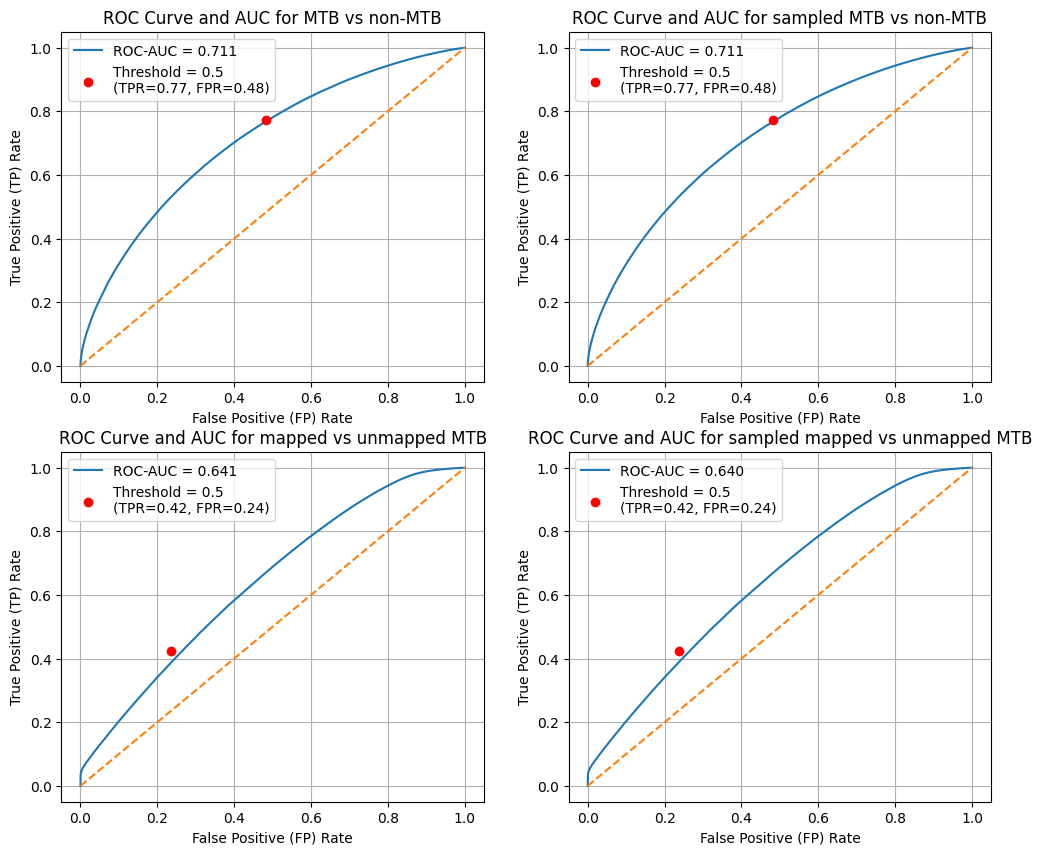

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(12,10))
x = 0
y = 0
plots = ["MTB vs non-MTB", "sampled MTB vs non-MTB", "mapped vs unmapped MTB", "sampled mapped vs unmapped MTB"]
i = 0

for preds_set in preds_list:
    
    # Pull each value as its designated definition
    TP = matrices[i][0][0]
    FN = matrices[i][0][1]
    FP = matrices[i][1][0]
    TN = matrices[i][1][1]
    # Calculate true positive rate and false positive rate
    tpr_p = TP / (TP+FN)
    fpr_p = FP / (FP+TN)
    
    # Check correct iteration
    print(x, y)
    # Compute roc curve
    fpr, tpr, roc_t = roc_curve(preds_set[0], preds_set[1])
    # Compute AUC
    rc_plot = auc(fpr, tpr)
    # For each prediction set, plot a ROC-AUC curve 
    axes[x,y].plot(fpr, tpr, label=f"ROC-AUC = {rc_plot:.3f}")
    axes[x,y].plot([0,1], [0,1], linestyle="--")
    # Place a spot for the model's performance in relation to the graph
    axes[x,y].scatter(fpr_p, tpr_p, color="red", zorder=5,
                label=f"Threshold = {0.5}\n(TPR={tpr_p:.2f}, FPR={fpr_p:.2f})")
    axes[x,y].set_xlabel("False Positive (FP) Rate")
    axes[x,y].set_ylabel("True Positive (TP) Rate")
    axes[x,y].legend()
    axes[x,y].grid(True)
    axes[x,y].set_title(f"ROC Curve and AUC for {plots[i]}")
    i += 1
    # Move horizontally if possible
    if y == 0:
        y += 1
    # Move vertically if needed
    elif y == 1:
        x = 1
        y = 0
        
    
    

Compute 4 graphs of Precision-Recall, each for each prediction run:

0 0
0 1
1 0
1 1


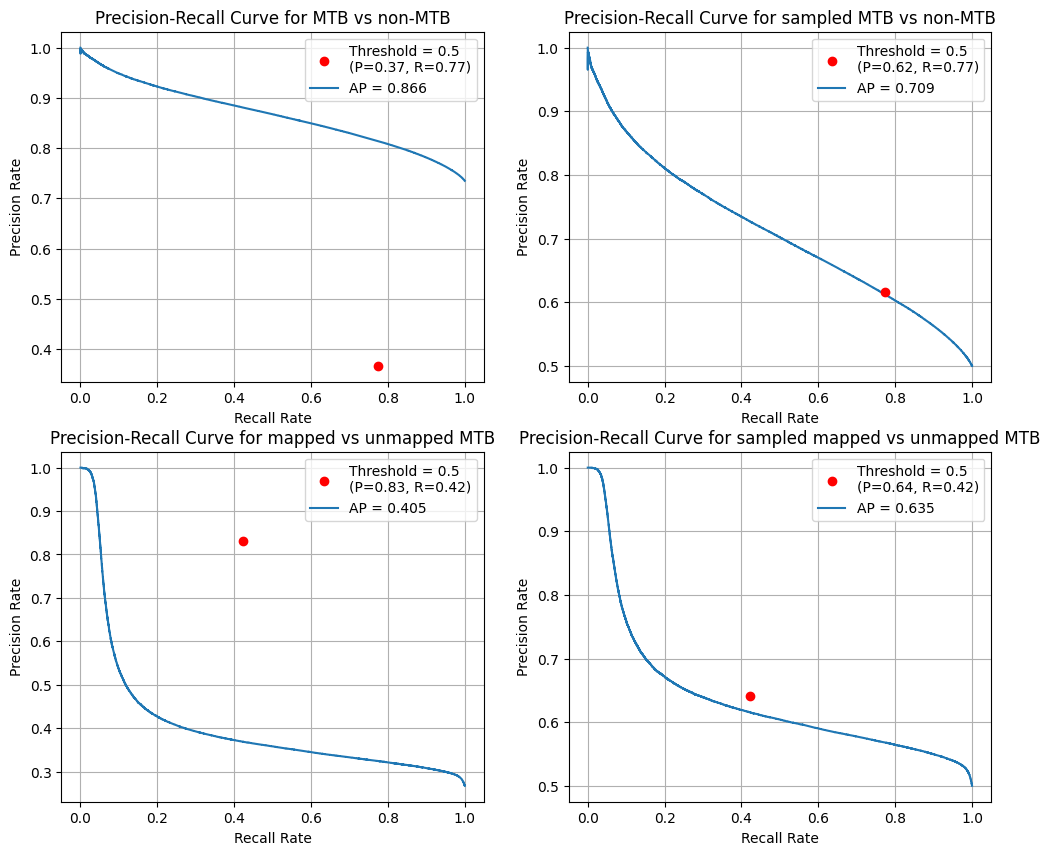

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(12,10))
x = 0
y = 0
plots = ["MTB vs non-MTB", "sampled MTB vs non-MTB", "mapped vs unmapped MTB", "sampled mapped vs unmapped MTB"]
i = 0

for preds_set in preds_list:
    # Check correct iteration 
    print(x, y)
    # Ensure correct classification with the set threshold
    pr = (preds_set[1] >= 0.5).astype(int)
    # Calculate precision score and recall score 
    p = precision_score(preds_set[0], pr, pos_label=0)
    r = recall_score(preds_set[0], pr, pos_label=0)
    # Calculate the Precision-Recall curve
    precision, recall, pr_tr = precision_recall_curve(preds_set[0], preds_set[1])
    # For each graph, place a spot for the model's performance in relation to the curve
    axes[x,y].scatter(r, p, color="red", label=f"Threshold = {0.5}\n(P={p:.2f}, R={r:.2f})", zorder=5)
    # Calculate the average precision score
    ap_score = average_precision_score(preds_set[0], preds_set[1])
    # For each prediction, plot the graph 
    axes[x,y].plot(recall, precision, label=f"AP = {ap_score:.3f}")
    axes[x,y].set_xlabel("Recall Rate")
    axes[x,y].set_ylabel("Precision Rate")
    axes[x,y].legend()
    axes[x,y].grid(True)
    axes[x,y].set_title(f"Precision-Recall Curve for {plots[i]}")
    i += 1
    # Move horizontally if possible
    if y == 0:
        y += 1
    # Move vertically if needed
    elif y == 1:
        x = 1
        y = 0